In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/MENg proj/'
npz_file = base_path + 'clean_noisy_eeg_segments.npz'
csv_file = base_path + 'segment_metadata.csv'

# Load EEG pairs and metadata
data = np.load(npz_file, allow_pickle=True)
noisy_data = data['noisy']
clean_data = data['clean']
metadata = pd.read_csv(csv_file)

print(f"Noisy EEG shape: {noisy_data.shape}")
print(f"Clean EEG shape: {clean_data.shape}")
print(f"Metadata shape: {metadata.shape}")
print(f"Total segments loaded: {len(clean_data)}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Noisy EEG shape: (8372, 14, 1280)
Clean EEG shape: (8372, 14, 1280)
Metadata shape: (8372, 4)
Total segments loaded: 8372


In [ ]:
!pip install torch==2.6.0 torchvision torchaudio --upgrade --quiet
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Compute global min and max across All data
all_values = np.concatenate([noisy_data.flatten(), clean_data.flatten()])
global_min, global_max = all_values.min(), all_values.max()

def global_minmax_scale(segment):
    """Scale a segment to [-1, 1] using the dataset-wide min and max."""
    return 2 * ((segment - global_min) / (global_max - global_min + 1e-8)) - 1

class EEGDataset(Dataset):
    def __init__(self, noisy, clean):
        self.noisy = [global_minmax_scale(seg) for seg in noisy]
        self.clean = [global_minmax_scale(seg) for seg in clean]

    def __len__(self):
        return len(self.noisy)

    def __getitem__(self, idx):
        noisy = torch.tensor(self.noisy[idx], dtype=torch.float32)
        clean = torch.tensor(self.clean[idx], dtype=torch.float32)
        return noisy.unsqueeze(0), clean.unsqueeze(0)  # (1,14,1280)

dataset = EEGDataset(noisy_data, clean_data)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


In [ ]:
import torch
import torch.nn as nn

# Self-Attention Module
class SelfAttention1D(nn.Module):
    def __init__(self, channels):
        super(SelfAttention1D, self).__init__()
        self.query = nn.Conv1d(channels, channels // 8, 1)
        self.key = nn.Conv1d(channels, channels // 8, 1)
        self.value = nn.Conv1d(channels, channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        B, C, L = x.size()
        query = self.query(x).view(B, -1, L)           # (B, C//8, L)
        key = self.key(x).view(B, -1, L)               # (B, C//8, L)
        energy = torch.bmm(query.permute(0, 2, 1), key) # (B, L, L)
        attention = torch.softmax(energy, dim=-1)
        value = self.value(x).view(B, -1, L)
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(B, C, L)
        return self.gamma * out + x

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(channels)

    def forward(self, x):
        identity = x
        out = self.prelu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return out + identity  # Skip connection


class EEGANetGenerator(nn.Module):
    def __init__(self, channels=14, residual_blocks=8):
        super(EEGANetGenerator, self).__init__()


        self.initial = nn.Sequential(
            nn.Conv1d(channels, 64, kernel_size=9, padding=4),
            nn.BatchNorm1d(64),
            nn.PReLU()
        )


        self.res_blocks = nn.Sequential(*[ResidualBlock(64) for _ in range(residual_blocks)])

        self.attention = SelfAttention1D(64)

        self.final = nn.Sequential(
            nn.Conv1d(64, channels, kernel_size=9, padding=4),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.res_blocks(x)
        x = self.attention(x)
        return self.final(x)


In [ ]:

generator = EEGANetGenerator(channels=14)

noisy_batch, clean_batch = next(iter(dataloader))  #[batch, 1, 14, 1280]

print("Input batch shape:", noisy_batch.shape)

# Flatten
noisy_batch_1d = noisy_batch.squeeze(1)  # Shape: [batch, 14, 1280]

# Pass through generator
output = generator(noisy_batch_1d)

print("Output shape:", output.shape)


Input batch shape: torch.Size([16, 1, 14, 1280])
Output shape: torch.Size([16, 14, 1280])


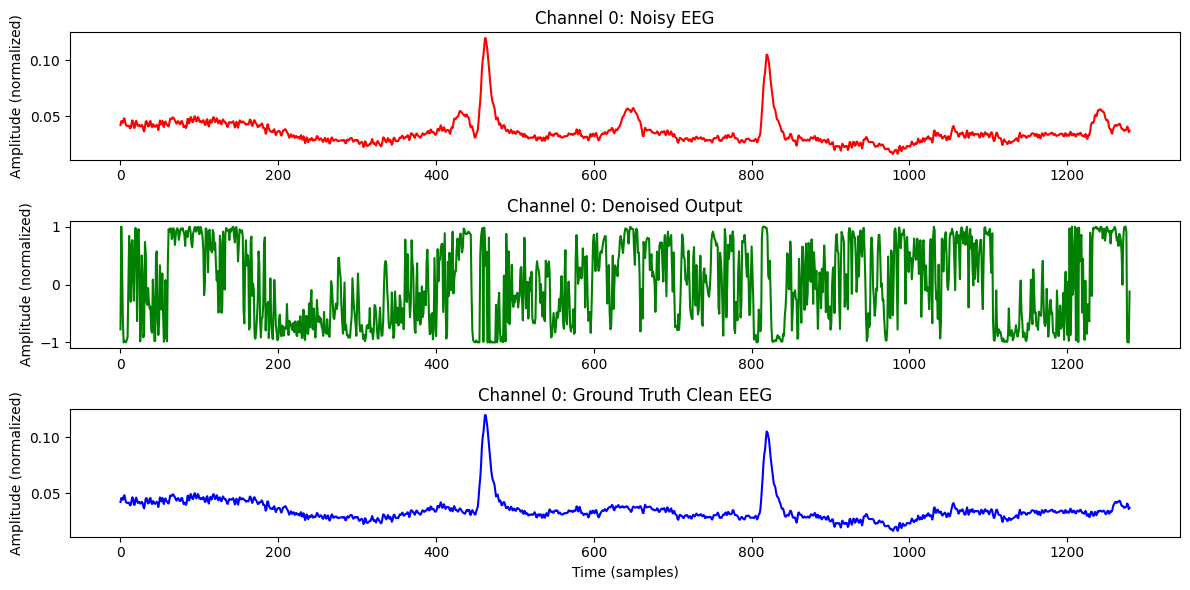

In [ ]:
import matplotlib.pyplot as plt
import random


noisy_batch, clean_batch = next(iter(dataloader))  #[batch, 1, 14, 1280]
idx = random.randint(0, noisy_batch.size(0) - 1)


noisy_seg = noisy_batch[idx].squeeze(0)
clean_seg = clean_batch[idx].squeeze(0)


with torch.no_grad():
    gen_output = generator(noisy_seg.unsqueeze(0))  # (1,14,1280)
gen_output = gen_output.squeeze(0).cpu()

# Select a single channel for plotting
channel = 0
time = range(noisy_seg.size(1))

plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(time, noisy_seg[channel].cpu(), label='Noisy Input', color='red')
plt.title(f'Channel {channel}: Noisy EEG')
plt.ylabel('Amplitude (normalized)')

plt.subplot(3, 1, 2)
plt.plot(time, gen_output[channel], label='Denoised (Generator)', color='green')
plt.title(f'Channel {channel}: Denoised Output')
plt.ylabel('Amplitude (normalized)')

plt.subplot(3, 1, 3)
plt.plot(time, clean_seg[channel].cpu(), label='Ground Truth (Clean)', color='blue')
plt.title(f'Channel {channel}: Ground Truth Clean EEG')
plt.ylabel('Amplitude (normalized)')
plt.xlabel('Time (samples)')

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn

class EEGANetDiscriminator(nn.Module):
    def __init__(self, channels=14):
        super(EEGANetDiscriminator, self).__init__()

        def conv_block(in_ch, out_ch, normalize=True):
            layers = [nn.Conv1d(in_ch, out_ch, kernel_size=4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_ch))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        self.model = nn.Sequential(
            conv_block(channels, 32, normalize=False),
            conv_block(32, 64),
            conv_block(64, 128),
            conv_block(128, 256),
            conv_block(256, 512),
            conv_block(512, 512),
            nn.Conv1d(512, 1, kernel_size=4, stride=1, padding=0),
            nn.Flatten(),
            nn.Linear(1 * ((1280 // (2**6)) - 3), 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
# Initialize the discriminator
discriminator = EEGANetDiscriminator(channels=14)


noisy_batch, clean_batch = next(iter(dataloader))
noisy_seg = noisy_batch.squeeze(1)
clean_seg = clean_batch.squeeze(1)

real_pred = discriminator(clean_seg)
print("Real EEG prediction shape:", real_pred.shape)
with torch.no_grad():
    fake_seg = generator(noisy_seg)
fake_pred = discriminator(fake_seg)
print("Fake EEG prediction shape:", fake_pred.shape)


Real EEG prediction shape: torch.Size([16, 1])
Fake EEG prediction shape: torch.Size([16, 1])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = EEGANetGenerator(channels=14).to(device)


mse_loss = nn.MSELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
epochs_pretrain = 5

for epoch in range(epochs_pretrain):
    total_loss = 0.0
    for noisy_batch, clean_batch in dataloader:
        noisy_batch = noisy_batch.squeeze(1).to(device)  # (batch, 14, 1280)
        clean_batch = clean_batch.squeeze(1).to(device)  # (batch, 14, 1280)

        optimizer_G.zero_grad()

        # Generate denoised EEG
        output = generator(noisy_batch)

        # Compute MSE loss
        loss = mse_loss(output, clean_batch)
        loss.backward()
        optimizer_G.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{epochs_pretrain}] - Avg MSE Loss: {avg_loss:.6f}")


Epoch [1/5] - Avg MSE Loss: 0.033664
Epoch [2/5] - Avg MSE Loss: 0.004505
Epoch [3/5] - Avg MSE Loss: 0.002216
Epoch [4/5] - Avg MSE Loss: 0.001386
Epoch [5/5] - Avg MSE Loss: 0.001010


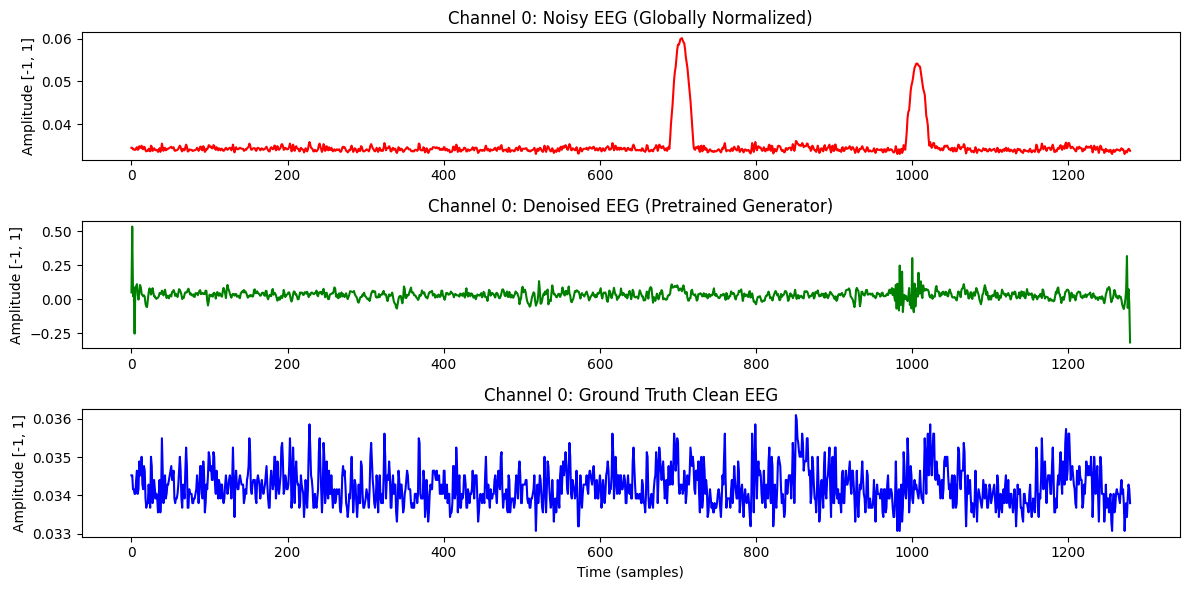

In [ ]:
import matplotlib.pyplot as plt
import random

# Pick a random batch and a random segment from it
noisy_batch, clean_batch = next(iter(dataloader))
idx = random.randint(0, noisy_batch.size(0) - 1)

noisy_seg = noisy_batch[idx].squeeze(0).to(device)
clean_seg = clean_batch[idx].squeeze(0).to(device)

# Run through pretrained generator
with torch.no_grad():
    gen_output = generator(noisy_seg.unsqueeze(0))
gen_output = gen_output.squeeze(0).cpu()


channel = 0
time = range(noisy_seg.size(1))

plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(time, noisy_seg[channel].cpu(), color='red')
plt.title(f'Channel {channel}: Noisy EEG (Globally Normalized)')
plt.ylabel('Amplitude [-1, 1]')

plt.subplot(3, 1, 2)
plt.plot(time, gen_output[channel], color='green')
plt.title(f'Channel {channel}: Denoised EEG (Pretrained Generator)')
plt.ylabel('Amplitude [-1, 1]')

plt.subplot(3, 1, 3)
plt.plot(time, clean_seg[channel].cpu(), color='blue')
plt.title(f'Channel {channel}: Ground Truth Clean EEG')
plt.ylabel('Amplitude [-1, 1]')
plt.xlabel('Time (samples)')

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim


generator = generator.to(device)
discriminator = EEGANetDiscriminator(channels=14).to(device)


mse_loss = nn.MSELoss()
bce_loss = nn.BCELoss()


optimizer_G = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))


epochs_gan = 20
lambda_adv = 1e-3

for epoch in range(epochs_gan):
    g_loss_total = 0.0
    d_loss_total = 0.0

    for noisy_batch, clean_batch in dataloader:
        noisy_batch = noisy_batch.squeeze(1).to(device)
        clean_batch = clean_batch.squeeze(1).to(device)

        batch_size = noisy_batch.size(0)
        real_labels = torch.ones((batch_size, 1), device=device)
        fake_labels = torch.zeros((batch_size, 1), device=device)

        # 1. Train Discriminator
        optimizer_D.zero_grad()

        # Predictions for real EEG
        real_preds = discriminator(clean_batch)
        d_loss_real = bce_loss(real_preds, real_labels)

        # Predictions for fake EEG
        fake_eeg = generator(noisy_batch).detach()
        fake_preds = discriminator(fake_eeg)
        d_loss_fake = bce_loss(fake_preds, fake_labels)

        # Total discriminator loss
        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        optimizer_D.step()


        # 2. Train Generator
        optimizer_G.zero_grad()

        # Generate fake EEG
        fake_eeg = generator(noisy_batch)
        preds_fake = discriminator(fake_eeg)
        loss_mse = mse_loss(fake_eeg, clean_batch)
        loss_adv = bce_loss(preds_fake, real_labels)

        # Combined generator loss
        g_loss = loss_mse + lambda_adv * loss_adv
        g_loss.backward()
        optimizer_G.step()

        g_loss_total += g_loss.item()
        d_loss_total += d_loss.item()

    # Average losses
    g_loss_avg = g_loss_total / len(dataloader)
    d_loss_avg = d_loss_total / len(dataloader)
    print(f"Epoch [{epoch+1}/{epochs_gan}] - G Loss: {g_loss_avg:.6f}, D Loss: {d_loss_avg:.6f}")

    save_dir = "/content/drive/MyDrive/MENg proj/saved_models"
    os.makedirs(save_dir, exist_ok=True)

    torch.save(generator.state_dict(), f"{save_dir}/generator_epoch{epoch+1}.pth")
    torch.save(discriminator.state_dict(), f"{save_dir}/discriminator_epoch{epoch+1}.pth")

    print(f"Models saved for epoch {epoch+1} at {save_dir}")

Epoch [1/20] - G Loss: 0.004648, D Loss: 0.304521
Models saved for epoch 1 at /content/drive/MyDrive/MENg proj/saved_models
Epoch [2/20] - G Loss: 0.005110, D Loss: 0.174027
Models saved for epoch 2 at /content/drive/MyDrive/MENg proj/saved_models
Epoch [3/20] - G Loss: 0.005880, D Loss: 0.138090
Models saved for epoch 3 at /content/drive/MyDrive/MENg proj/saved_models
Epoch [4/20] - G Loss: 0.005933, D Loss: 0.145155
Models saved for epoch 4 at /content/drive/MyDrive/MENg proj/saved_models
Epoch [5/20] - G Loss: 0.005950, D Loss: 0.115271
Models saved for epoch 5 at /content/drive/MyDrive/MENg proj/saved_models
Epoch [6/20] - G Loss: 0.006637, D Loss: 0.098695
Models saved for epoch 6 at /content/drive/MyDrive/MENg proj/saved_models
Epoch [7/20] - G Loss: 0.006315, D Loss: 0.101618
Models saved for epoch 7 at /content/drive/MyDrive/MENg proj/saved_models
Epoch [8/20] - G Loss: 0.006703, D Loss: 0.114265
Models saved for epoch 8 at /content/drive/MyDrive/MENg proj/saved_models
Epoch [9

In [ ]:
import numpy as np

def compute_snr(clean, denoised):
    noise = clean - denoised
    power_signal = np.sum(clean ** 2)
    power_noise = np.sum(noise ** 2) + 1e-8
    return 10 * np.log10(power_signal / power_noise)

def compute_correlation(clean, denoised):
    # Flatten signals
    clean_flat = clean.flatten()
    denoised_flat = denoised.flatten()
    return np.corrcoef(clean_flat, denoised_flat)[0, 1]


generator.eval()

mse_list, snr_list, corr_list = [], [], []

with torch.no_grad():
    for noisy_batch, clean_batch in dataloader:
        noisy_batch = noisy_batch.squeeze(1).to(device)
        clean_batch = clean_batch.squeeze(1).to(device)

        # Generate denoised EEG
        denoised_batch = generator(noisy_batch).cpu().numpy()
        clean_batch_np = clean_batch.cpu().numpy()

        for clean_seg, denoised_seg in zip(clean_batch_np, denoised_batch):
            mse = np.mean((clean_seg - denoised_seg) ** 2)
            snr = compute_snr(clean_seg, denoised_seg)
            corr = compute_correlation(clean_seg, denoised_seg)
            mse_list.append(mse)
            snr_list.append(snr)
            corr_list.append(corr)

avg_mse = np.mean(mse_list)
avg_snr = np.mean(snr_list)
avg_corr = np.mean(corr_list)

print(f"Average MSE: {avg_mse:.4f}")
print(f"Average SNR: {avg_snr:.2f} dB")
print(f"Average Correlation: {avg_corr:.4f}")


Average MSE: 0.0027
Average SNR: 7.53 dB
Average Correlation: 0.8803


In [ ]:
import matplotlib.pyplot as plt
import random

# Select a random segment from the dataset
generator.eval()
noisy_batch, clean_batch = next(iter(dataloader))
idx = random.randint(0, noisy_batch.size(0) - 1)

noisy_seg = noisy_batch[idx].squeeze(0).to(device)
clean_seg = clean_batch[idx].squeeze(0).to(device)

# Generate denoised EEG
with torch.no_grad():
    denoised_seg = generator(noisy_seg.unsqueeze(0)).squeeze(0).cpu()

noisy_seg = noisy_seg.cpu()
clean_seg = clean_seg.cpu()

time = range(noisy_seg.shape[1])

# Plot each channel in its own subplot
fig, axes = plt.subplots(14, 1, figsize=(15, 25), sharex=True)

for ch in range(14):
    axes[ch].plot(time, noisy_seg[ch], color='red', alpha=0.6, label='Noisy')
    axes[ch].plot(time, denoised_seg[ch], color='green', alpha=0.8, label='Denoised')
    axes[ch].plot(time, clean_seg[ch], color='blue', alpha=0.8, label='Clean')
    axes[ch].set_ylabel(f"Ch {ch}")
    if ch == 0:
        axes[ch].legend(loc="upper right", fontsize=8)

axes[-1].set_xlabel("Time (samples)")
plt.suptitle("EEG Segment: Noisy vs Denoised vs Clean (All Channels)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


NameError: name 'generator' is not defined